Calcolo ground state classico

In [34]:
import numpy as np
from numpy import linalg
from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.opflow import Z, I, X

nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=2
m=num_qubits-1
n=num_qubits-2
E_l = []
P_l = []
energy_levels = []


for k in range(len(b)):
    G=b[k]*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(n+1-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b[k]*G
    
    hamiltonian=Operator(hamiltonian1+hamiltonian2)
    
    # Extract eig
    E_l,P_l = linalg.eig(hamiltonian.data)

    Es = np.sort(E_l)

    energy_levels.append(np.real(Es))
    
    

Calcolo ground state quantistico

In [25]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit.utils import QuantumInstance
from qiskit.opflow import Z, I, X
from qiskit.circuit.library import EfficientSU2
import numpy as np

#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [35]:
#provider.backends()

In [27]:
optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0)
#optimizer = SPSA(maxiter=50)
###############################

HW = 'ibmq_manila'
BK = "noiseless" # "noiseless", "hardware"

if BK == "noiseless":
    
    backend = Aer.get_backend("qasm_simulator")
    quantum_instance = QuantumInstance(backend,
                                       shots=nShots)
    
if BK == "noisy":
    
    device = IBMQ.get_provider().get_backend(HW)
    coupling_map = device.configuration().coupling_map
    prop = device.properties()
    
    noise_model = noise.device.basic_device_noise_model(prop)
    basis_gates = noise_model.basis_gates

    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend,
                                       shots=nShots,
                                       noise_model=noise_model,
                                       coupling_map=coupling_map)
    
if BK == "hardware":
    
    device = provider.get_backend(HW)
    prop = device.properties()
    
    quantum_instance = QuantumInstance(device,
                                       shots=nShots)

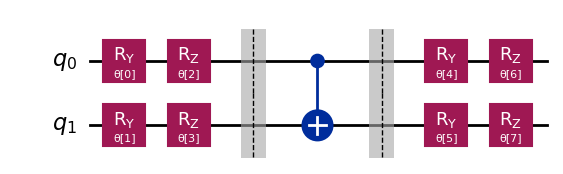

In [28]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

In [29]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [30]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [31]:
from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

energy = []

for k in range(len(b)):
    G=b[k]*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(n+1-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b[k]*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    
    # Extract eig
    local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)
    energy.append(local_result.eigenvalue)


C:\Users\Fabio\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


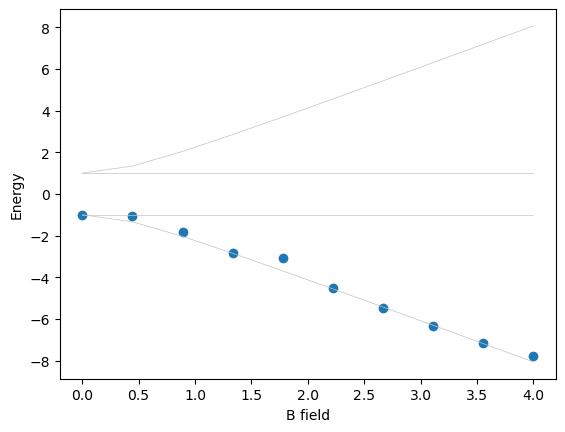

In [33]:
##VERY ROUGH RESULTS WITHOUT OPTIMIZATION
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#plt.xticks(b)

ax.scatter(b, energy, marker='o')
ax.plot(b, energy_levels, color="#c2c2c2", linewidth=0.5)

ax.set(xlabel='B field', ylabel='Energy', title='')

#ax.grid()
plt.show()

## ADDITIONAL DETAILS: https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/03_vqe_simulation_with_noise.ipynb